In [2]:
IS_OSC = False

In [74]:
# Setup script to run on OSC
# conda install scikit-learn matplotlib nltk seaborn
# pip install git+https://github.com/titipata/pubmed_parser.git@0.3.1
# conda install -c conda-forge hummingbird-ml
# conda install ipykernel
# ipython kernel install --user --name=thesis


In [59]:
if IS_OSC:
    try:
        import pubmed_parser
    except ImportError as e:
        %pip install git+https://github.com/titipata/pubmed_parser.git@0.3.1
    try:
        import sklearn
    except ImportError as e:
        %pip install scikit-learn
    try:
        import hummingbird.ml
    except ImportError as e:
        %pip install hummingbird-ml
        %pip install torch
    try:
        import matplotlib
    except ImportError as e:
        %pip install matplotlib
    try:
        from nltk.corpus import stopwords
    except ImportError as e:
        import nltk
        nltk.download('stopwords')
    try:
        import seaborn
    except ImportError as e:
        %pip install seaborn
    import nltk
    nltk.download('stopwords')

In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
import pubmed_parser as pp
import csv
from tqdm import tqdm
from hummingbird.ml import convert

import warnings
warnings.filterwarnings('ignore')

Let's look at one pub-med dictionary entry:

In [3]:
if IS_OSC:
    data_path = "/ftp.ncbi.nlm.nih.gov/pubmed/baseline/"
else:
    data_path = '../../data/raw'
path_xml = pp.list_xml_path(data_path) # list all xml paths under directory
pubmed_dict = pp.parse_medline_xml(path_xml[0]) # dictionary output

Load it into a dataframe and output the head

In [4]:
df = pd.DataFrame(pubmed_dict)
df.head()

,title,issue,pages,abstract,journal,authors,pubdate,pmid,mesh_terms,publication_types,...,doi,references,delete,affiliations,pmc,other_id,medline_ta,nlm_unique_id,issn_linking,country
0,[Beta-blockers and arterial hypertension in th...,7(31),2807-9,,La Nouvelle presse medicale,Tcherdakoff|P|P|,1978,30970,D000319:Adrenergic beta-Antagonists; D005260:F...,D016428:Journal Article,...,,,False,,,,Nouv Presse Med,0312552,0301-1518,France
1,[beta-blockers and high risk pregnancies. View...,7(31),2811-2,,La Nouvelle presse medicale,Dubois|D|D|;Petitcolas|J|J|,1978,30971,D000070:Acebutolol; D000319:Adrenergic beta-An...,D016428:Journal Article,...,,,False,,,,Nouv Presse Med,0312552,0301-1518,France
2,[Surface defense mechanisms of the nasal mucosa].,33(35),1391-3,,"Polski tygodnik lekarski (Warsaw, Poland : 1960)",Makowska|W|W|;Zawisza|E|E|,1978,30972,D001424:Bacterial Infections; D002633:Chemotax...,D016428:Journal Article; D016454:Review,...,,,False,,,,Pol Tyg Lek,9705468,0032-3756,Poland
3,[Pharmacological treatment of coronary disease].,33(44),1721-4,,"Polski tygodnik lekarski (Warsaw, Poland : 1960)",Krotkiewski|A|A|,1978,30973,D000319:Adrenergic beta-Antagonists; D003327:C...,D016428:Journal Article,...,,,False,,,,Pol Tyg Lek,9705468,0032-3756,Poland
4,Treating the outpatient schizophrenic.,64(5),48-56,,Postgraduate medicine,Gelenberg|A J|AJ|,1978,30974,D000208:Acute Disease; D000553:Ambulatory Care...,D016428:Journal Article,...,10.1080/00325481.1978.11714969,,False,,,,Postgrad Med,0401147,0032-5481,England


Get the unique mesh terms

In [5]:
mesh_terms_arr = []
[mesh_terms_arr.extend(mesh_terms.split('; ')) for mesh_terms in df.mesh_terms.to_list()]
unique_mesh_terms = set(mesh_terms_arr)

# Display the first 20 unique terms
list(unique_mesh_terms)[:20]

['D001058:Apomorphine',
 'D010555:Personality Inventory',
 'D005954:Glucosephosphate Dehydrogenase',
 'D000369:Aged, 80 and over',
 'D011197:Potassium Radioisotopes',
 'D014317:Tritolyl Phosphates',
 'D005513:Food Inspection',
 'D015004:Yellow Fever',
 'D015226:Dinucleoside Phosphates',
 'D009302:Nasopharyngeal Diseases',
 'D004825:Epiglottis',
 'D001886:Bordetella pertussis',
 'D000883:Anthropology',
 'D005609:Free Radicals',
 'D006428:Hemipelvectomy',
 'D049668:History, 15th Century',
 'D006408:Hematoma, Subdural',
 'D006551:Hernia, Hiatal',
 'D010529:Peritoneal Cavity',
 'D016193:G1 Phase']

Add the mesh terms to the dataframe as columns. This does take about 5 minutes to run per volume.

In [6]:
for mesh_term in tqdm(unique_mesh_terms):
    df[mesh_term] = df.mesh_terms.apply(lambda x: 1 if mesh_term in x else 0)

100%|██████████| 10792/10792 [02:44<00:00, 65.71it/s]


Display the head of the dataframe to see if the mesh terms were added

In [7]:
df.head()

,title,issue,pages,abstract,journal,authors,pubdate,pmid,mesh_terms,publication_types,...,D010559:Personnel Management,D015119:Aminocaproic Acid,D000075:Acepromazine,D014594:Uterine Neoplasms,"D016920:Meningitis, Bacterial",D009029:Mosaic Viruses,D009108:Mumps Vaccine,D007417:Intestinal Polyps,D007165:Immunosuppression Therapy,D013229:Stearic Acids
0,[Beta-blockers and arterial hypertension in th...,7(31),2807-9,,La Nouvelle presse medicale,Tcherdakoff|P|P|,1978,30970,D000319:Adrenergic beta-Antagonists; D005260:F...,D016428:Journal Article,...,0,0,0,0,0,0,0,0,0,0
1,[beta-blockers and high risk pregnancies. View...,7(31),2811-2,,La Nouvelle presse medicale,Dubois|D|D|;Petitcolas|J|J|,1978,30971,D000070:Acebutolol; D000319:Adrenergic beta-An...,D016428:Journal Article,...,0,0,0,0,0,0,0,0,0,0
2,[Surface defense mechanisms of the nasal mucosa].,33(35),1391-3,,"Polski tygodnik lekarski (Warsaw, Poland : 1960)",Makowska|W|W|;Zawisza|E|E|,1978,30972,D001424:Bacterial Infections; D002633:Chemotax...,D016428:Journal Article; D016454:Review,...,0,0,0,0,0,0,0,0,0,0
3,[Pharmacological treatment of coronary disease].,33(44),1721-4,,"Polski tygodnik lekarski (Warsaw, Poland : 1960)",Krotkiewski|A|A|,1978,30973,D000319:Adrenergic beta-Antagonists; D003327:C...,D016428:Journal Article,...,0,0,0,0,0,0,0,0,0,0
4,Treating the outpatient schizophrenic.,64(5),48-56,,Postgraduate medicine,Gelenberg|A J|AJ|,1978,30974,D000208:Acute Disease; D000553:Ambulatory Care...,D016428:Journal Article,...,0,0,0,0,0,0,0,0,0,0


Get the counts of the mesh terms

In [8]:
mesh_term_counts = []
for mesh_term in tqdm(unique_mesh_terms):
    mesh_term_counts.append((mesh_term, df[mesh_term].sum()))
mesh_term_counts = sorted(mesh_term_counts, key=lambda x: x[1], reverse=True)
mesh_term_df = pd.DataFrame(mesh_term_counts, columns=['mesh_term', 'count'])
mesh_term_df.head(20)

100%|██████████| 10792/10792 [00:01<00:00, 7528.92it/s]


,mesh_term,count
0,D006801:Humans,17259
1,D000818:Animals,10858
2,D008297:Male,7775
3,D005260:Female,7299
4,D006863:Hydrogen-Ion Concentration,4507
5,D000328:Adult,4177
6,D051381:Rats,3487
7,D008875:Middle Aged,3093
8,D013997:Time Factors,2285
9,D051379:Mice,1945


Plot the top 20 mesh terms

<AxesSubplot: xlabel='mesh_term'>

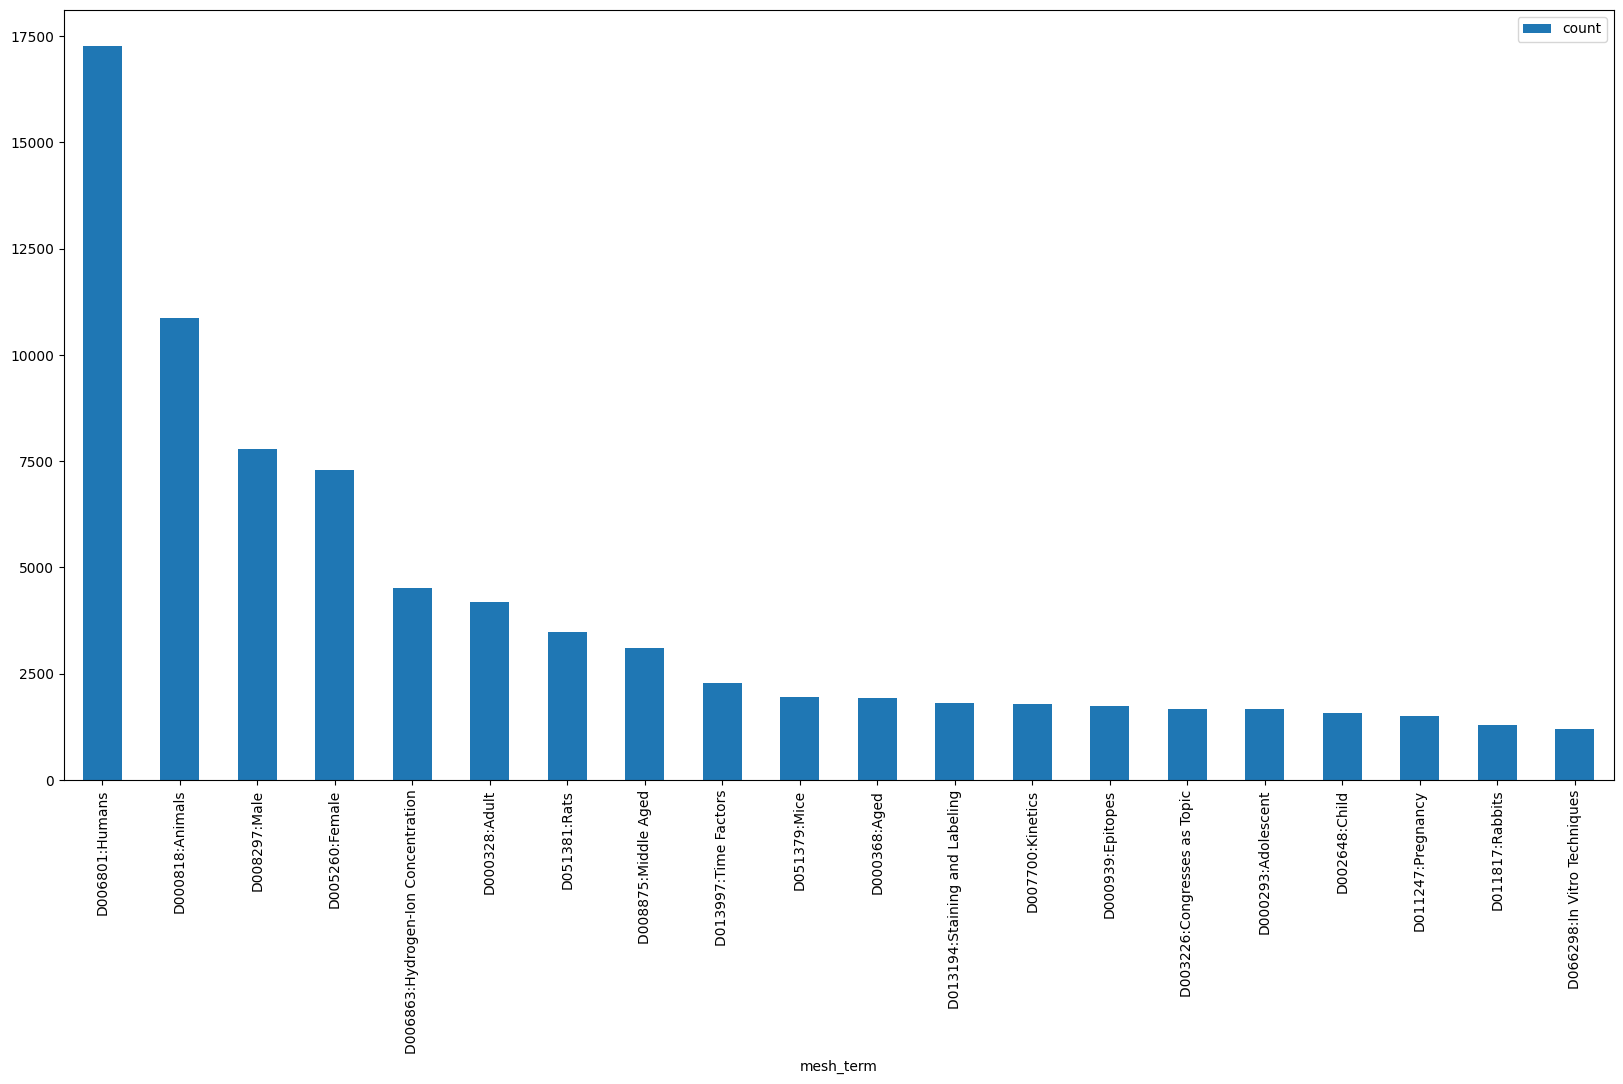

In [9]:
mesh_term_df.head(20).plot.bar(x='mesh_term', y='count', figsize=(20, 10))

How many mesh terms are there per article?

In [10]:

count_of_mesh_terms_per_article = df.iloc[:,22:].sum(axis=1).value_counts()


<AxesSubplot: >

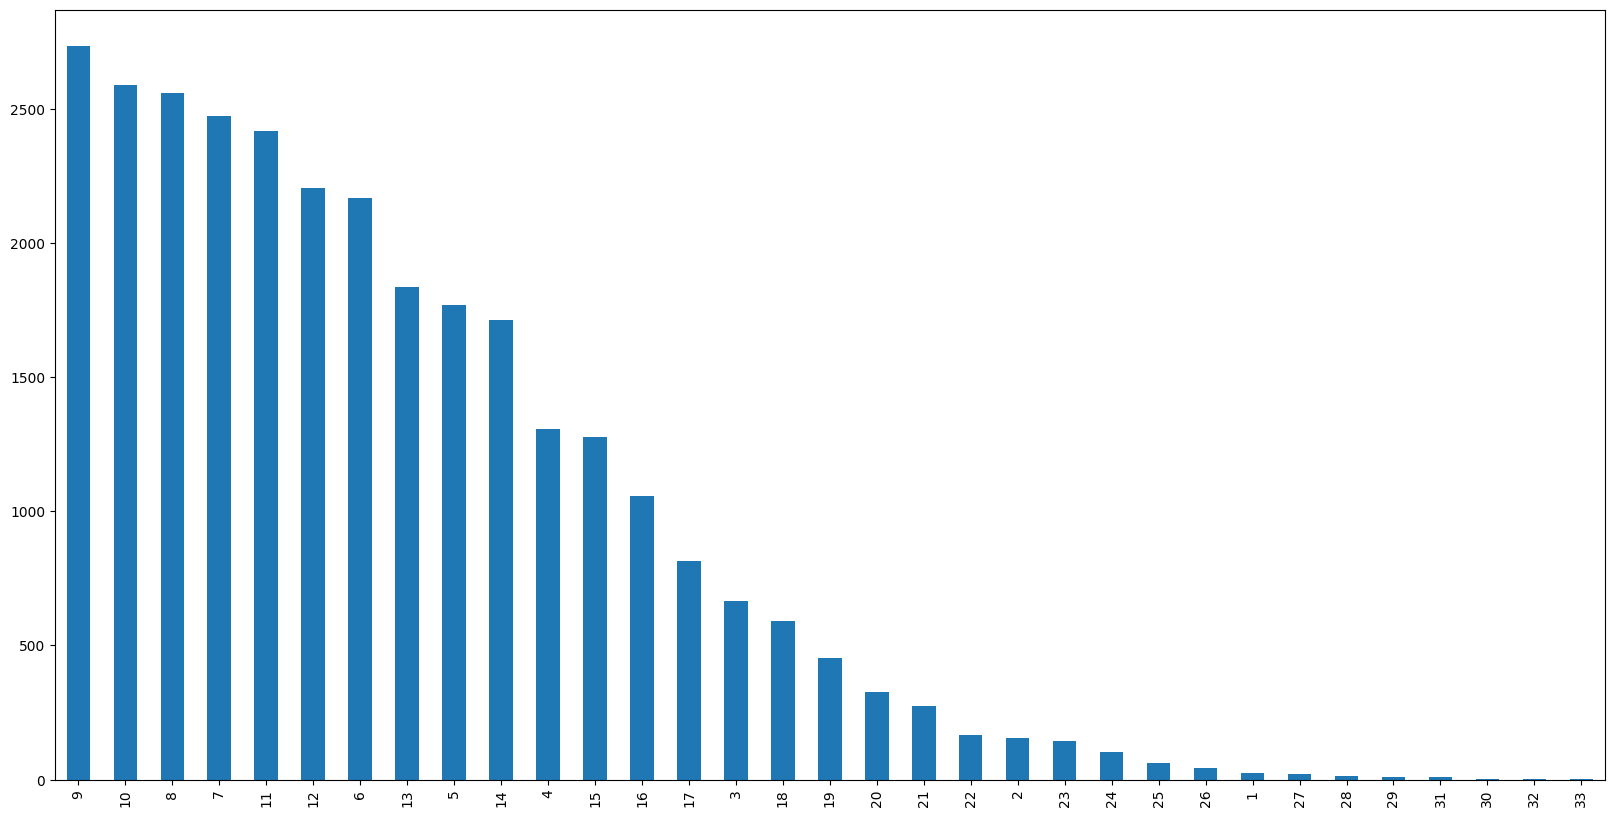

In [11]:
count_of_mesh_terms_per_article.plot.bar(figsize=(20, 10))

Let's start training and testing

In [12]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [13]:
X_train = train.abstract
X_test = test.abstract
print(X_train.shape)
print(X_test.shape)

(20100,)
(9900,)


Create a pipeline with a multi label classifier

In [14]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

with open('accuracy.csv','w') as f1:
    writer=csv.writer(f1, delimiter=',',lineterminator='\n')
    writer.writerow(['mesh_term','accuracy','precision','recall'])
    for mesh_term in tqdm(unique_mesh_terms):
        # train the model using X_dtm & y
        NB_pipeline.fit(X_train, train[mesh_term])
        # compute the testing accuracy
        if IS_OSC:
            model = convert(NB_pipeline, 'pytorch')
            model.to('cuda')
            prediction = model.predict(X_test)
        else:
            prediction = NB_pipeline.predict(X_test)
        print('Term: {}'.format(mesh_term))
        print('Test accuracy is {}'.format(accuracy_score(test[mesh_term], prediction)))
        print('Test precision is {}'.format(precision_score(test[mesh_term], prediction)))
        print('Test recall is {}'.format(recall_score(test[mesh_term], prediction)))
        writer.writerow([
            mesh_term, 
            accuracy_score(test[mesh_term], prediction), 
            precision_score(test[mesh_term], prediction), 
            recall_score(test[mesh_term], prediction)
            ])

  0%|          | 1/10792 [00:01<4:38:44,  1.55s/it]

Term: D001058:Apomorphine
Test accuracy is 0.9973737373737374
Test precision is 0.0
Test recall is 0.0


  0%|          | 2/10792 [00:03<4:38:34,  1.55s/it]

Term: D010555:Personality Inventory
Test accuracy is 0.9996969696969698
Test precision is 0.0
Test recall is 0.0


  0%|          | 3/10792 [00:04<4:29:31,  1.50s/it]

Term: D005954:Glucosephosphate Dehydrogenase
Test accuracy is 0.9980808080808081
Test precision is 0.0
Test recall is 0.0


  0%|          | 4/10792 [00:05<4:25:07,  1.47s/it]

Term: D000369:Aged, 80 and over
Test accuracy is 0.99989898989899
Test precision is 0.0
Test recall is 0.0


  0%|          | 5/10792 [00:07<4:24:56,  1.47s/it]

Term: D011197:Potassium Radioisotopes
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 6/10792 [00:08<4:28:33,  1.49s/it]

Term: D014317:Tritolyl Phosphates
Test accuracy is 0.99989898989899
Test precision is 0.0
Test recall is 0.0


  0%|          | 7/10792 [00:10<4:27:53,  1.49s/it]

Term: D005513:Food Inspection
Test accuracy is 0.99989898989899
Test precision is 0.0
Test recall is 0.0


  0%|          | 8/10792 [00:12<4:41:08,  1.56s/it]

Term: D015004:Yellow Fever
Test accuracy is 0.99989898989899
Test precision is 0.0
Test recall is 0.0


  0%|          | 9/10792 [00:13<4:34:53,  1.53s/it]

Term: D015226:Dinucleoside Phosphates
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 10/10792 [00:15<4:33:28,  1.52s/it]

Term: D009302:Nasopharyngeal Diseases
Test accuracy is 1.0
Test precision is 0.0
Test recall is 0.0


  0%|          | 11/10792 [00:17<4:56:13,  1.65s/it]

Term: D004825:Epiglottis
Test accuracy is 0.99989898989899
Test precision is 0.0
Test recall is 0.0


  0%|          | 12/10792 [00:18<4:46:09,  1.59s/it]

Term: D001886:Bordetella pertussis
Test accuracy is 0.998989898989899
Test precision is 0.0
Test recall is 0.0


  0%|          | 13/10792 [00:20<4:54:20,  1.64s/it]

Term: D000883:Anthropology
Test accuracy is 0.99989898989899
Test precision is 0.0
Test recall is 0.0


  0%|          | 14/10792 [00:21<4:51:31,  1.62s/it]

Term: D005609:Free Radicals
Test accuracy is 0.9993939393939394
Test precision is 0.0
Test recall is 0.0


  0%|          | 15/10792 [00:23<4:46:40,  1.60s/it]

Term: D006428:Hemipelvectomy
Test accuracy is 0.99989898989899
Test precision is 0.0
Test recall is 0.0


  0%|          | 15/10792 [00:24<4:56:15,  1.65s/it]


KeyboardInterrupt: 

In [21]:


for mesh_term in list(unique_mesh_terms)[:2]:
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[mesh_term])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Term: {}'.format(mesh_term))
    print(test[mesh_term].sum())
    print('Test accuracy is {}'.format(accuracy_score(test[mesh_term], prediction)))
    print('Test precision is {}'.format(precision_score(test[mesh_term], prediction)))
    print('Test recall is {}'.format(recall_score(test[mesh_term], prediction)))

Term: D001058:Apomorphine
26
0
Test accuracy is 0.9973737373737374
Test precision is 0.0
Test recall is 0.0
Term: D010555:Personality Inventory
3
0
Test accuracy is 0.9996969696969698
Test precision is 0.0
Test recall is 0.0
